In [1]:
%matplotlib inline

In [2]:
import os,sys
from __future__ import division, print_function
import numpy as np, scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing

from scipy import signal, io, special, fftpack
from scipy.io import wavfile
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 12,6

In [3]:
os.chdir('/home/mike/ve/ml/')
from eegkaggle.dio import dataio
from eegkaggle.msignal import auxfilter

In [4]:
def tanh2(x, a=1, b=1, c=1, d=1):
    e_x = np.exp(x)
    e_nx = np.exp(-x)
    return (a*e_x - c*e_nx)/(b*e_x + d*e_nx)

def softplus(x, a=1):
    return np.log(1+np.exp((x+1)*a))/a -1

def softclip(x, a=1):
    x = softplus(x, a)
    
    return -np.log(1+np.exp((-x+1)*a))/a +1

In [5]:
def norm_softclip_eeg(data, sigma=8, zeta=10, global_pow=None ):
    """Sigma is the range of std dev the signal is normed to 1, e.g. sigma=6 means the +/-6-sigma line is set to +/-1
    zeta is the soft-knee coefficient of soft clip. Higher zeta means harder clip, but less distortion"""
    zdata = np.array(data - np.mean(data, axis=0))
    std = np.std(zdata) if global_pow is None else global_pow
        
    zdata /= (sigma*std)
    return softclip(zdata, zeta)

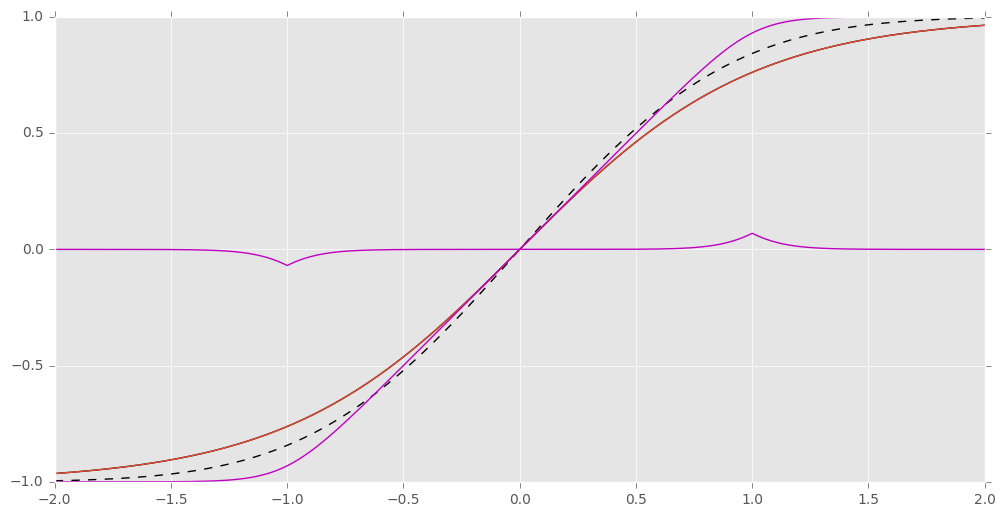

In [6]:
x = np.linspace(-2,2,1000)
plt.plot(x, special.erf(x), 'k--')
# plt.plot(x, special.erf(x*2)/2)
plt.plot(x, tanh2(x), 'k')
plt.plot(x, tanh2(x, 2,1,2,1)/2)
# plt.plot(x, softplus(x,1))
# plt.plot(x, softplus(x,4))
plt.plot(x, softclip(x,10), 'm')
plt.plot(x, np.clip(x,-1,1)-softclip(x,10), 'm')

plt.axis('equal')
print()

In [7]:
deltazeta = []
for i in range(4,20): 
    deltazeta.append(np.amax(np.clip(x,-1,1)-softclip(x,i)))

# plt.plot(deltazeta)

In [8]:
path = '/home/mike/data/train/1_104_1.mat'
data = dataio.get_matlab_eeg_data_ary(path)
data.shape

(240000, 16)

In [9]:
print(np.mean(data, axis=0))
print(np.std(data, axis=0))
print(np.amin(data, axis=0))
print(np.amax(data, axis=0))
print(np.mean(np.mean(data, axis=0)), np.std(np.mean(data, axis=0)))
print(np.mean(np.std(data, axis=0)), np.std(np.std(data, axis=0)))
print(np.mean(np.amin(data, axis=0)), np.std(np.amin(data, axis=0)))
print(np.mean(np.amax(data, axis=0)), np.std(np.amax(data, axis=0)))

[ -5.18798835e-08  -1.11275064e-02   9.90191177e-02  -8.24626759e-02
   8.98401663e-02  -1.43486172e-01  -5.36223128e-02  -2.44907796e-01
  -1.50363997e-01  -2.71688849e-01  -2.02876210e-01   2.45378479e-01
   4.53334332e-01   3.61395717e-01   3.50878298e-01   7.29801431e-02]
[  45.91293335   47.13775635   61.16132736   77.47942352   54.86563873
   46.61429214   47.95576859   39.66411972   47.4900589    61.36686707
   76.18666077  111.2939682    93.03366852   92.60277557  100.38872528
   52.638237  ]
[ -239.45295715  -265.05657959  -381.13858032  -381.18649292 -1478.59216309
  -548.22320557  -284.94042969  -486.44168091  -320.4854126   -517.24914551
  -552.07769775  -694.45196533  -758.89837646  -756.18341064  -708.11968994
  -330.07449341]
[ 270.54702759  292.94342041  386.86141968  423.81350708  532.40783691
  311.77679443  235.05958557  289.55831909  279.5145874   549.75085449
  500.92230225  643.54803467  555.10162354  411.          627.88031006
  277.92550659]
0.0320182 0.217111
6

In [10]:
compdata = norm_softclip_eeg(data, sigma=8)

''

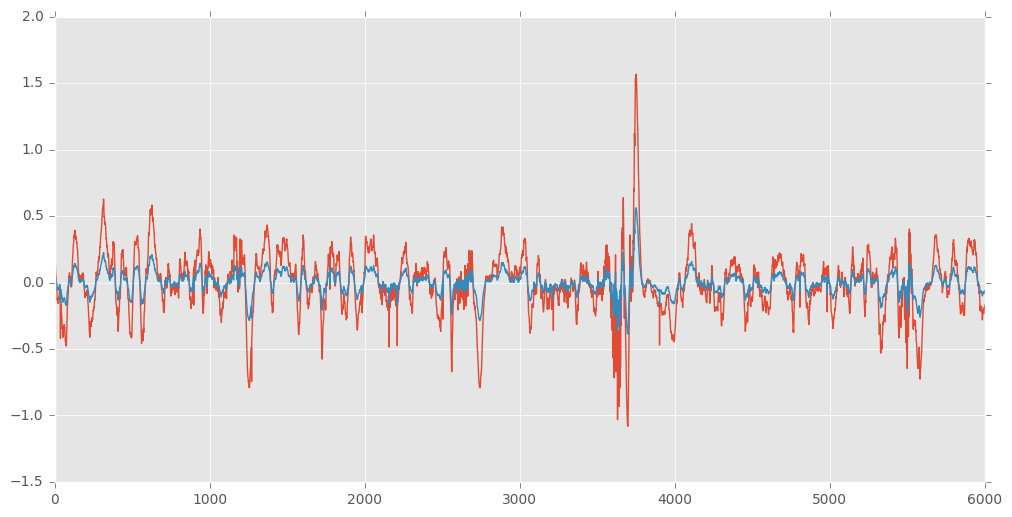

In [11]:
t1 = 6000
ch = 9
plt.plot(data[:t1,ch]/200)
plt.plot(compdata[:t1, ch])
''

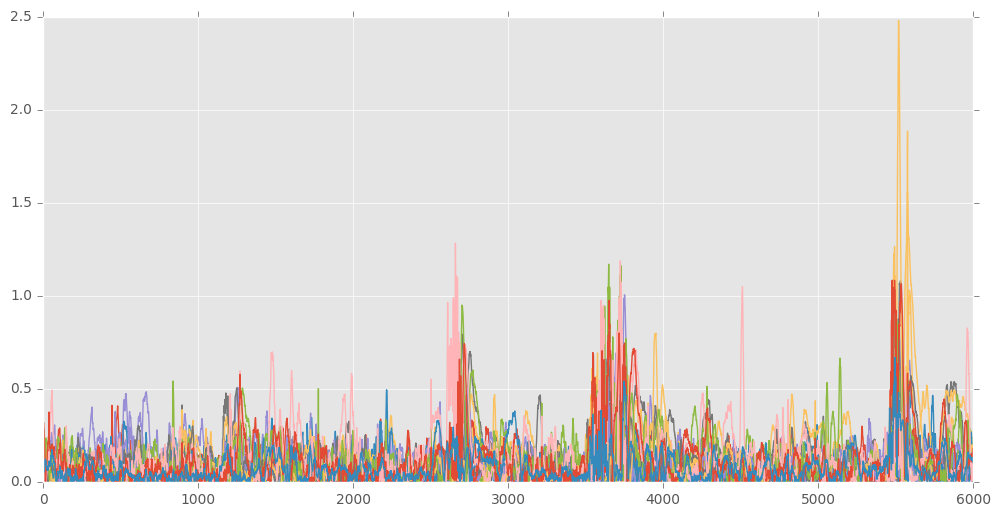

In [12]:
plt.plot((np.abs((data/200-compdata))[:t1]))

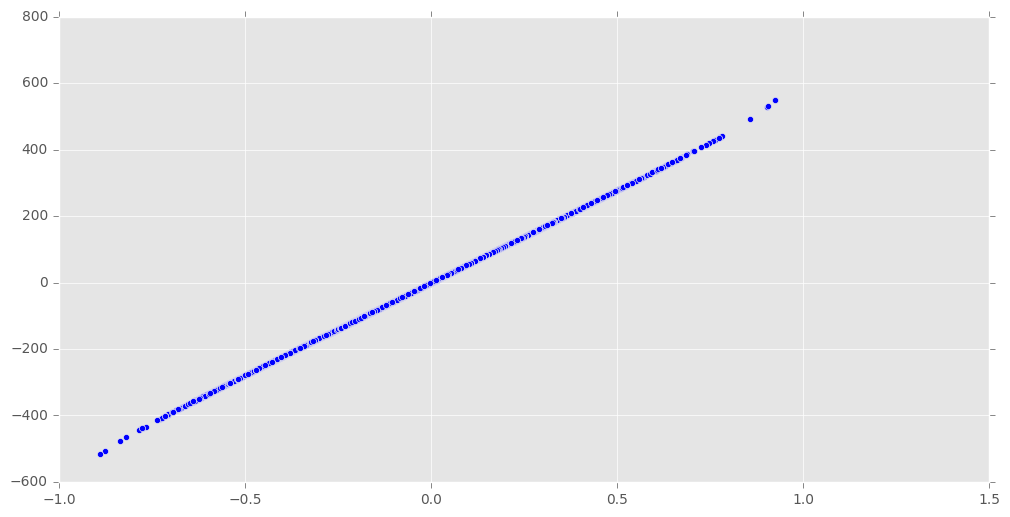

In [13]:
ch = 9
skip = 1
plt.scatter(compdata[::skip,ch], data[::skip,ch])

''

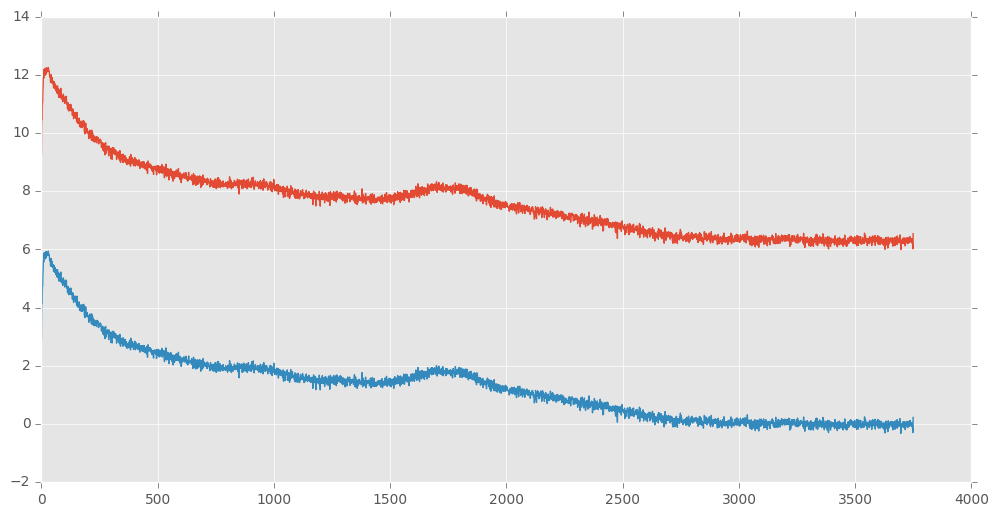

In [14]:
cutoff = 120000
fft0 = fftpack.fft(data, axis=0)
fft1 = fftpack.fft(compdata, axis=0)
down = 32
afft0 = np.abs(fft0[:cutoff])
afft0 = signal.resample_poly(afft0, 1, down, axis=0)#auxfilter.butterfilt(afft0, cutoff=0.1)
afft1 = np.abs(fft1[:cutoff])
afft1 = signal.resample_poly(afft1, 1, down, axis=0)#auxfilter.butterfilt(afft0, cutoff=0.1)

ch = 15
plt.plot(np.log(afft0[:,ch]))
plt.plot(np.log(afft1[:,ch]))
''

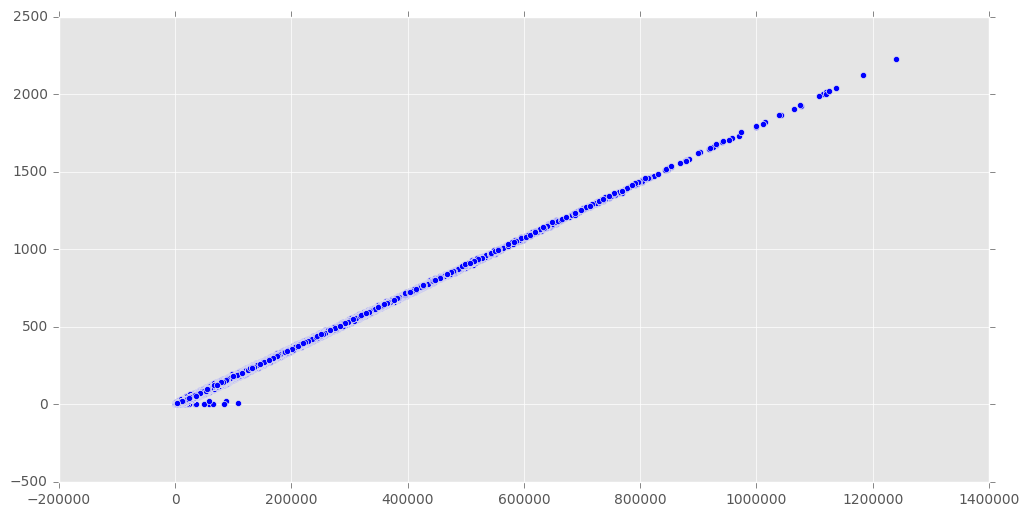

In [15]:
plt.scatter(np.abs(fft0[:,:]), np.abs(fft1[:,:]))

In [21]:
# DC pass all samples individually
dc_mean = np.mean(data, axis=0)
zdata = data - dc_mean
print(np.mean(np.std(zdata, axis=0)), np.std(np.std(zdata, axis=0)))
print(np.mean(np.var(zdata, axis=0)), np.std(np.var(zdata, axis=0)))
zdata = data / np.std(data)

65.987 22.012
4838.81 3263.46


In [22]:
np.std(zdata, axis=0)

array([ 0.66002965,  0.67763728,  0.87923568,  1.11381936,  0.7887308 ,
        0.67011213,  0.68939674,  0.57019871,  0.68270189,  0.88219023,
        1.09523499,  1.59992635,  1.33742225,  1.33122778,  1.44315624,
        0.75671047], dtype=float32)

''

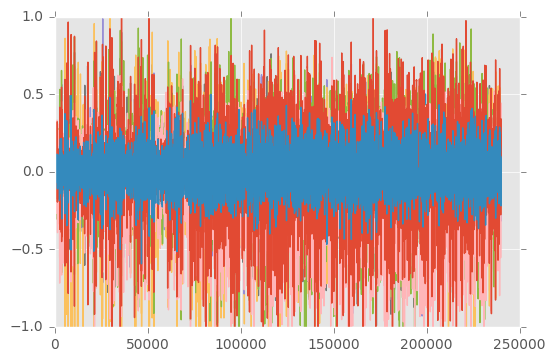

In [70]:
plt.plot(np.clip(zdata[:]/8, -1,1))
''

''

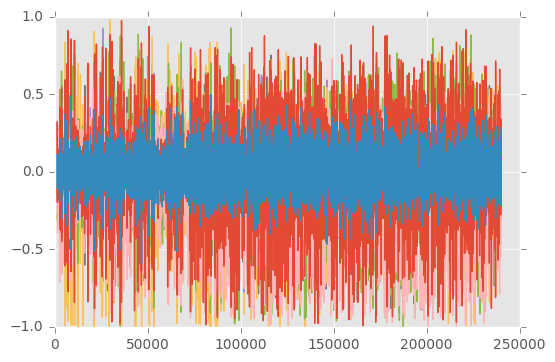

In [71]:
plt.plot(norm_softclip_eeg(zdata/8))
''

/home/mike/ve/ml/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


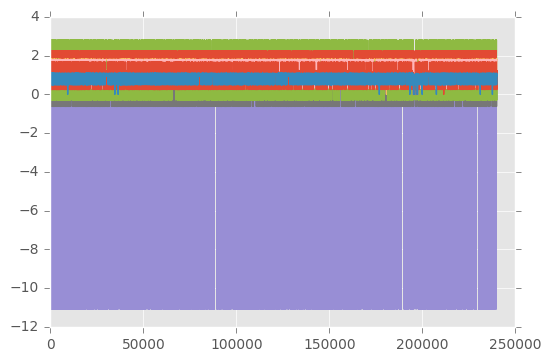

In [30]:
plt.plot(.125*zdata /  norm_softclip_eeg(zdata))

In [ ]:
data_c = np.clip(data, -400,400)
plt.plot(np.ones(data.shape[0]) * 10, 'k--')
plt.plot(np.ones(data.shape[0]) * -10, 'k--')

plt.plot(data_c, alpha=0.2)
''

In [ ]:
plt.plot(preprocessing.robust_scale(data, axis=0), alpha=0.2)
''

In [ ]:
scaled_data = softclip(zdata/6) #preprocessing.MinMaxScaler([-1,1]).fit_transform(data)
scaled_data -= np.mean(scaled_data, axis=0)
scaled_data = np.clip(scaled_data, -1, 1)
plt.plot(scaled_data, alpha=0.2)
print(np.mean(scaled_data, axis=0))
print(np.std(scaled_data, axis=0))
''

In [ ]:
evens = scaled_data[:, 0::2]
odds = scaled_data[:, 1::2]
print(data.shape, evens.shape, odds.shape)

In [ ]:
print(data.shape[0]*4, data.shape[0]*8 )

In [ ]:
channel_count = evens.shape[1]

In [ ]:
plt.plot(evens, alpha=0.4)

In [ ]:
evenstack_l = np.vstack([evens[:, [i]] for i in range(0, channel_count, 2)])
evenstack_r = np.vstack([evens[:, [i]] for i in range(1, channel_count, 2)]) 
oddstack_l = np.vstack([odds[:, [i]] for i in range(0, channel_count, 2)])
oddstack_r = np.vstack([odds[:, [i]] for i in range(1, channel_count, 2)]) 

print(evenstack_l.shape, evenstack_r.shape, oddstack_l.shape, oddstack_r.shape)

In [ ]:
evenstack = np.concatenate([evenstack_l, evenstack_r], axis=1)
oddstack = np.concatenate([oddstack_l, oddstack_r], axis=1)

print(evenstack.shape)

In [ ]:
datastack = np.concatenate([evenstack, oddstack], axis=0)
print(datastack.shape)

In [ ]:
plt.plot(datastack, alpha=0.5)

In [ ]:
sample_rate = 44100
wavfile.write('teststereo1.wav', sample_rate, np.int16(datastack * 2 ** 15))